In [5]:
!pip3 install rtree

In [6]:
import os
import rtree
import matplotlib.pyplot as plt
import random
import numpy as np

import torch

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
workind_directory = "/content/drive/MyDrive/Map_construction/source"
os.chdir(workind_directory)
os.getcwd()

'/content/drive/MyDrive/Map_construction/source'

In [9]:
data_folder = "../data/"
maps_path = data_folder + "maps/"
tracks_path = data_folder + "tracks/"

In [10]:
dataset = "chicago_cropped"

In [11]:
def read_map(maps_path, dataset):
    vertices_path = maps_path + dataset + "/" + dataset + "_vertices_osm.txt"
    edges_path = maps_path + dataset + "/" + dataset + "_edges_osm.txt"
    vertices = {}
    
    nodes_index = rtree.Index()
    nodes_neighbours = {}
    
    with open(vertices_path) as f:
        for line in f:
            temp = line.strip('\n').split(',')
            if temp[0] in vertices.keys(): # If there are two nodes with the same id
                print("Lolaso")
            x, y = float(temp[1]), float(temp[2])
            vertices[temp[0]] = (x, y)
            nodes_index.insert(int(temp[0]), (x, y))
            
    edges = {}
    with open(edges_path) as f:
        for line in f:
            temp = line.strip('\n').split(',')
            edges[temp[0]] = (vertices[temp[1]], vertices[temp[2]])
            if temp[1] in nodes_neighbours.keys():
                nodes_neighbours[temp[1]][temp[2]] = temp[0] #(neighbour, edge_id)
            else:
                nodes_neighbours[temp[1]] = {temp[2]: temp[0]} #(neighbour, edge_id)
            
            if temp[2] in nodes_neighbours.keys():
                nodes_neighbours[temp[2]][temp[1]] = temp[0] #(neighbour, edge_id)
            else:
                nodes_neighbours[temp[2]] = {temp[1]: temp[0]} #(neighbour, edge_id)
                
            
    
    
            
    return vertices, edges, nodes_index, nodes_neighbours

In [12]:
def read_tracks(tracks_path, dataset):
    current_tracks_path = tracks_path + dataset + "/trips/"
    trip_files = os.listdir(current_tracks_path)
    idx2gps_points = {}
    idx = 0
    traj_index = rtree.Index()
    trajectories = {}
    for trip in trip_files:
        trip_path = current_tracks_path + trip
        trip_id = int(trip.split('_')[-1].split('.')[0]) ## trip_XXX.txt
        trip_point_id = 0
        track = []
        with open(trip_path) as f:
            for line in f:
                x, y, z = line.strip('\n').split(' ')
                x, y, z = float(x), float(y), float(z)
                track.append((x, y, z))
                traj_index.insert(idx, (x, y))
                idx2gps_points[idx] = (trip_id, trip_point_id)
                idx += 1
                trip_point_id += 1

        trajectories[trip_id] = track
            
    return trajectories, traj_index, idx2gps_points

In [13]:
def rotate_traj(set_traj, omega, center = (0,0)):
    rotation_matrix = np.array([[np.cos(omega), -np.sin(omega), 0],
                                [np.sin(omega), np.cos(omega), 0],
                                [0, 0, 1]])
    
    center3d = np.array(list(center) + [0])

    rotated_set_traj = []

    for traj in set_traj:
        traj_matrix = np.matrix(traj)
        centered_traj_matrix = traj_matrix - center3d
        centered_rotated_traj = np.einsum('...ij,...j', rotation_matrix, centered_traj_matrix)
        rotated_traj = centered_rotated_traj + center3d
        rotated_set_traj.append(rotated_traj)

    return rotated_set_traj


def rotate_edges(set_edges, omega, center = (0,0)):
    rotation_matrix = np.array([[np.cos(omega), -np.sin(omega)],
                                [np.sin(omega), np.cos(omega)]])
    
    center3d = np.array(center)

    rotated_set_edges = {}

    for edge_id, (in_node, out_node) in set_edges.items():
        nodes_matrix = np.matrix((in_node, out_node))
        centered_nodes_matrix = nodes_matrix - center3d
        centered_rotated_nodes = np.einsum('...ij,...j', rotation_matrix, centered_nodes_matrix)
        rotated_nodes = centered_rotated_nodes + center3d
        in_node, out_node = rotated_nodes
        in_node = tuple(np.array(in_node).squeeze())
        out_node = tuple(np.array(out_node).squeeze())
        rotated_set_edges[edge_id] = (in_node, out_node)

    return rotated_set_edges


def choose_omega():
    a = random.random()
    if a < 1/4:
        return 0
    else:
        omega = random.choice([-60, -30, 30, 60, 90])
        return omega

In [20]:
def get_tile_traces(trajectories, traj_index, idx2gps_points, center, omega = 0, size = 500, rotation = 0):

    xmin = center[0] - size/2
    xmax = center[0] + size/2
    ymin = center[1] - size/2
    ymax = center[1] + size/2
    
    intersected_points = list(traj_index.intersection((xmin, ymin, xmax, ymax)))
    
    traj_intersected = {}
    for point_id in intersected_points:
        trip_id, trip_point_id = idx2gps_points[point_id]
        if trip_id in traj_intersected.keys():
            traj_intersected[trip_id].append(trip_point_id)
        else:
            traj_intersected[trip_id] = [trip_point_id]
    
    set_traj = []
    for trip_id in traj_intersected.keys():
        intersected_points = sorted(traj_intersected[trip_id])
        initial_point = intersected_points[0]
        for i in range(len(intersected_points)-1):
            if intersected_points[i] + 1 != intersected_points[i+1] or i == len(intersected_points)-2:
                set_traj.append(trajectories[trip_id][initial_point:intersected_points[i]+1])
                initial_point = intersected_points[i+1]


    # rotated_set_traj = rotate_traj(set_traj, omega)


    return set_traj

In [21]:
def normalize_traj(set_traj, center, max_length = 30*3):
    new_set_traj = []
    for i, traj in enumerate(set_traj):
        traj = np.array(traj).flatten()
        traj[0::3] = traj[0::3] - center[0]
        traj[1::3] = traj[1::3] - center[1]
        mean_height = np.mean(traj[2::3])
        traj[2::3] = traj[2::3] - mean_height
        new_set_traj.append(traj)
        
    return new_set_traj

def filter_set_traj(set_traj, max_length = 30*3, min_length = 2*3):
    #first center traj, then add zeros
    set_traj = normalize_traj(set_traj, center)
    
    new_set_traj = []
    for traj in set_traj:
        if len(traj) > min_length:
            if len(traj) > max_length:
                traj = traj[:max_length]
            len_traj = len(traj)
            new_array = np.zeros(max_length)
            new_array[:len_traj] = traj
            
            new_set_traj.append(new_array)
            
    new_set_traj = np.matrix(new_set_traj)
    
    return new_set_traj

In [22]:
def get_tile_map(edges, nodes_index, nodes_neighbours, center, size = 500):
    xmin = center[0] - size/2
    xmax = center[0] + size/2
    ymin = center[1] - size/2
    ymax = center[1] + size/2
    
    intersected_points = list(nodes_index.intersection((xmin, ymin, xmax, ymax)))
    
    # print(intersected_points)
    edges_intersected = {}
    set_edges = {}
    for point_id in intersected_points:
        point_id = str(point_id)
        if point_id in nodes_neighbours.keys():
            for neighbour in nodes_neighbours[point_id].keys():
                # print(point_id, neighbour, neighbour in intersected_points, type(intersected_points[1]), type(neighbour))
                if int(neighbour) in intersected_points and nodes_neighbours[point_id][neighbour] not in set_edges.keys():
                    set_edges[nodes_neighbours[point_id][neighbour]] = edges[nodes_neighbours[point_id][neighbour]]
    
    return set_edges

def draw_line(x0, y0, x1, y1):

    def sign(a):
        if a>0:
            ret = 1
        elif a<0:
            ret = -1
        else:
            ret = 0
        return ret

    x = x0
    y = y0
    dx = abs(x1-x)
    dy = abs(y1-y)
    s1 = sign(x1-x0)
    s2 = sign(y1-y0)

    if dy>dx:
        dx, dy = dy, dx
        interchange = 1
    else:
        interchange = 0

    # print("dx : ",dx,"\ndy : ",dy)
    e = 2*dy - dx
    # print("e : ",e)
    # print("interchange :", interchange,"\n")
    #display list
    x_list = []
    y_list = []
    x_ = []
    y_ = []
    e_ = []

    for i in range(dx):
        x_list.append(x)
        y_list.append(y)
        while(e>=0):
            if interchange==1:
                x = x +s1

            else:
                y = y + s2

            e = e - 2*dx
        if interchange==1:
            y = y + s2

        else:
            x = x + s1
            
        e = e + 2*dy
        e_.append(e)

    return x_list, y_list


def edges2image(set_edges, cells = 32, size = 500, omega = np.pi/4):

    true_size = size*(abs(np.cos(omega))+abs(np.sin(omega)))

    extra_cells = int(np.ceil(true_size/(size/cells)) - cells)

    # print("True size", true_size, "Extra_cells:", extra_cells)

    if extra_cells % 2 != 0:
        extra_cells += 1

    true_cells = cells + extra_cells

    # print("True size", true_size, "True_cells:", true_cells)

    true_image = np.zeros((true_cells, true_cells))

    

    for edge in set_edges.keys():
        x, y = set_edges[edge]
    
        x0 = int((x[0] - center[0] + true_size/2) // (true_size/true_cells))
        x1 = int((x[1] - center[1] + true_size/2) // (true_size/true_cells))
        y0 = int((y[0] - center[0] + true_size/2) // (true_size/true_cells))
        y1 = int((y[1] - center[1] + true_size/2) // (true_size/true_cells))

        x_list, y_list = draw_line(x0, x1, y0, y1)

        true_image[y_list,x_list] = 1
         

    margin = extra_cells//2
    image = true_image[margin:(true_cells-margin), margin:(true_cells-margin)]
    
    return np.matrix(image)

In [23]:
vertices, edges, nodes_index, nodes_neighbours = read_map(maps_path, dataset)

In [24]:
trajectories, traj_index, idx2gps_points = read_tracks(tracks_path, dataset)

In [38]:
maps_path

'../data/maps/'

In [25]:
def get_distance(p1, p2):
    return np.sqrt((p2[0]-p1[0])**2 + (p2[1]-p1[1])**2)

def get_edges_span(edges):
    total_distance = 0
    dist2edges = {}
    for edge in edges.keys():
        in_node, out_node = edges[edge]
        dist = get_distance(in_node, out_node)
        
        total_distance += dist
        dist2edges[total_distance] = edge
        
    return dist2edges, total_distance


def distance_along_line(p1, p2, alpha):
    vector = (p2[0]-p1[0], p2[1]-p1[1])
    final_point = (p1[0] + alpha*vector[0], p1[1] + alpha*vector[1])
    
    return final_point

def get_center(distance, dist2edges, edges):
    sorted_limits = sorted(list(dist2edges.keys()))
    prev = 0
    for current_limit in sorted_limits:
        if distance <= current_limit:
            slot = current_limit
            break
        else:
            prev = current_limit
    
    alpha = (distance-prev)/(slot-prev)
    edge_id = dist2edges[slot]
    in_node, out_node = edges[edge_id]
    center = distance_along_line(in_node, out_node, alpha)
    return center

In [26]:
def save_array(array, folder_path, name):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    path = folder_path + "/" + name
    with open(path, "w") as f:
        for line in array:
            np.savetxt(f, line, fmt='%.10f', delimiter=',')

In [27]:
dist2edges, total_distance = get_edges_span(edges)

In [28]:
size = 500

random_distance = random.random() * 12000
center = get_center(random_distance, dist2edges, edges)

set_traj = get_tile_traces(trajectories, traj_index, idx2gps_points, center, size)
set_edges = get_tile_map(edges, nodes_index, nodes_neighbours, center, size)

omega = np.pi/2

rotated_edges = rotate_edges(set_edges, omega, center)
rotated_trajectories = rotate_traj(set_traj, omega, center)

### Create dataset

In [ ]:
dataset_name = "500m_chicago_cropped_rotated_15k"
folder = "/".join(os.getcwd().split("/")[:-1])

In [ ]:
folder = "/".join(os.getcwd().split("/")[:-1])
folder_path = folder + "/data/datasets/" + dataset_name + "/" + str(0)
print(folder_path)


/content/drive/My Drive/Map_construction/data/datasets/500m_chicago_cropped_rotated_15k/0


In [ ]:
rotate_traj(set_traj, omega, center)
rotate_edges(set_edges, omega, center)

In [29]:
n = 10000
size = 500 # meters
cells = 32

data = []
centers = []
omegas = []

for i in range(n):
    print(i, end = "\r")
    random_distance = random.random() * total_distance
    center = get_center(random_distance, dist2edges, edges)
    omega = choose_omega()
    omegas.append(omega)

    set_traj = get_tile_traces(trajectories, traj_index, idx2gps_points, center, size)
    set_traj = rotate_traj(set_traj, omega, center)
    array_set_traj = filter_set_traj(set_traj)
    
    set_edges = get_tile_map(edges, nodes_index, nodes_neighbours, center, size)
    set_edges = rotate_edges(set_edges, omega, center)
    image = edges2image(set_edges, cells, size, omega)
    
    """
    folder_path = folder + "/data/datasets/" + dataset_name + "/" + str(i)
    
    file_traj = "traj" + str(i) + "_" + str(center[0]) + "," + str(center[1]) + ".txt"
    # save_array(array_set_traj, folder_path, file_traj)
    
    file_image = "image" + str(i) + "_" + str(center[0]) + "," + str(center[1]) + ".txt"
    # save_array(image, folder_path, file_image)
    """
    obs = (torch.Tensor(array_set_traj), torch.Tensor(image))
    
    
    data.append(obs)
    centers.append(center)

In [ ]:
import pickle 


data_path_pickle = folder + "/data/datasets/" + dataset_name + "/" + "data.pickle"

with open(data_path_pickle, 'wb') as f_data:
    pickle.dump(data, f_data)

In [ ]:
centers_path_pickle = folder + "/data/datasets/" + dataset_name + "/" + "centers.pickle"

with open(centers_path_pickle, 'wb') as f_centers:
    pickle.dump(centers, f_centers)

## Show inputs outputs

In [30]:
data[0][0]

tensor([[-241.8661, -151.8474,  -37.2174,  ...,    0.0000,    0.0000,
            0.0000],
        [-245.3734, -154.5954,  -23.8333,  ...,    0.0000,    0.0000,
            0.0000],
        [-237.5387, -150.3273,  -22.7895,  ...,    0.0000,    0.0000,
            0.0000],
        ...,
        [-239.5055, -157.6399,  -28.4762,  ...,    0.0000,    0.0000,
            0.0000],
        [-232.7256, -171.2400,  -24.6667,  ...,    0.0000,    0.0000,
            0.0000],
        [-233.2683,   -9.6808,  -10.0000,  ...,    0.0000,    0.0000,
            0.0000]])

In [34]:
random_idx = random.randint(0, len(idx2gps_points)-1)
trip_id, gps_point = idx2gps_points[random_idx]
center = trajectories[trip_id][gps_point][:2]
size = 500

In [35]:

set_traj = get_tile_traces(trajectories, traj_index, idx2gps_points, center, size)
set_edges = get_tile_map(edges, nodes_index, nodes_neighbours, center, size)
print(len(set_traj))


232


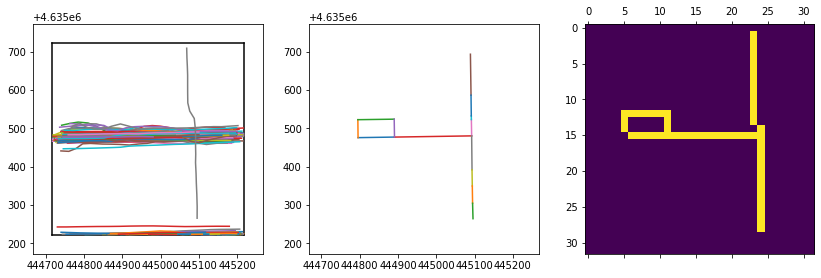

In [36]:
fig = plt.figure(figsize=(14,12))
ax = fig.add_subplot(131)
zoom = 1.2
omega = 0
plt.xlim(center[0]-zoom*size/2, center[0]+zoom*size/2)
plt.ylim(center[1]-zoom*size/2, center[1]+zoom*size/2)
ax.set_aspect('equal')

ax.plot([center[0]-size/2,center[0]+size/2], [center[1]-size/2, center[1]-size/2], c = "black")
ax.plot([center[0]-size/2,center[0]+size/2], [center[1]+size/2, center[1]+size/2], c = "black")
ax.plot([center[0]-size/2,center[0]-size/2], [center[1]-size/2, center[1]+size/2], c = "black")
ax.plot([center[0]+size/2,center[0]+size/2], [center[1]-size/2, center[1]+size/2], c = "black")

for selected_traj in rotate_traj(set_traj, omega, center):
    x = [coords[0] for coords in selected_traj]
    y = [coords[1] for coords in selected_traj]
    ax.plot(x, y)
    
ax = fig.add_subplot(132)
plt.xlim(center[0]-zoom*size/2, center[0]+zoom*size/2)
plt.ylim(center[1]-zoom*size/2, center[1]+zoom*size/2)
ax.set_aspect('equal')
rotated_edges = rotate_edges(set_edges, omega, center)
for edge in rotated_edges.keys():
    p1, p2 = rotated_edges[edge]
    ax.plot([p1[0], p2[0]], [p1[1], p2[1]])
    
ax = fig.add_subplot(133)
cells = 32
image = edges2image(rotated_edges, cells, size, omega)

ax.matshow(image[::-1])
    
plt.show()

In [ ]:
500/np.sin(np.pi/4)

707.1067811865476

Check trajectories length

In [ ]:
traj_lengths = []
size = 2000

for i in range(200):
    random_distance = random.random() * total_distance
    center = get_center(random_distance, dist2edges, edges)

    set_traj = get_tile_traces(trajectories, traj_index, idx2gps_points, center, size)
    for traj in set_traj:
        traj_lengths.append(len(traj))

(array([1.160e+03, 1.229e+03, 1.192e+03, 1.252e+03, 9.400e+02, 7.840e+02,
        9.280e+02, 1.470e+03, 1.564e+03, 1.793e+03, 1.815e+03, 1.679e+03,
        1.584e+03, 1.517e+03, 1.561e+03, 2.071e+03, 2.826e+03, 3.902e+03,
        5.776e+03, 6.922e+03, 3.760e+03, 1.618e+03, 1.440e+03, 1.426e+03,
        1.286e+03, 1.083e+03, 9.130e+02, 8.520e+02, 8.610e+02, 7.740e+02,
        6.360e+02, 4.380e+02, 3.590e+02, 2.660e+02, 1.400e+02, 1.080e+02,
        7.800e+01, 6.800e+01, 6.100e+01, 3.900e+01, 1.900e+01, 1.500e+01,
        1.000e+01, 7.000e+00, 1.000e+01, 2.400e+01, 3.500e+01, 3.300e+01,
        1.800e+01, 4.000e+00, 5.000e+00, 3.000e+00, 7.000e+00, 1.000e+01,
        5.000e+00, 6.000e+00, 5.000e+00, 1.000e+00, 2.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 2.000e+00,
        8.000e+00, 6.000e+00, 3.000e+00, 1.000e+00]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 

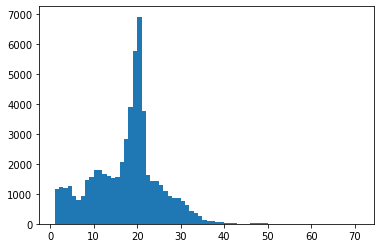

In [ ]:
plt.hist(traj_lengths, bins=range(min(traj_lengths), max(traj_lengths)+2, 1))